# COMP90051 Project 2

In [1]:
# Do not edit. These are the only imports permitted.
import numpy as np
from abc import ABC, abstractmethod
from sklearn.tree import DecisionTreeClassifier   # for Task 4
from sklearn.base import clone                    # optional for Task 4
import random
import matplotlib.pyplot as plt                   # for Task 5
from sklearn.metrics.pairwise import rbf_kernel   # for Task 6

In [2]:
class MAB(ABC):
    """Base class for a contextual multi-armed bandit (MAB)
    
    Parameters
    ----------
    n_arms : int
        Number of arms.
    """
    def __init__(self, n_arms):
        if not np.issubdtype(type(n_arms), np.integer):
            raise TypeError("`n_arms` must be an integer")
        if not n_arms >= 0:
            raise ValueError("`n_arms` must be non-negative")
        self.n_arms = n_arms
        # your code here (if you like)
        
    @abstractmethod
    def play(self, context):
        """Play a round
        
        Parameters
        ----------        
        context : float numpy.ndarray, shape (n_arms, n_dims), optional
            An array of context vectors presented to the MAB. The 0-th 
            axis indexes the arms, and the 1-st axis indexes the features.
            Non-contextual bandits accept a context of None.
        
        Returns
        -------
        arm : int
            Integer index of the arm played this round. Should be in the set 
            {0, ..., n_arms - 1}.
        """
        # your code here (if you like)
    
    @abstractmethod
    def update(self, arm, reward, context):
        """Update the internal state of the MAB after a play
        
        Parameters
        ----------
        arm : int
            Integer index of the played arm in the set {0, ..., n_arms - 1}.
        
        reward : float
            Reward received from the arm.
        
        context : float numpy.ndarray, shape (n_arms, n_dims), optional
            An array of context vectors that was presented to the MAB. The 
            0-th axis indexes the arms, and the 1-st axis indexes the 
            features. Non-contextual bandits accept a context of None. 
        """
        # your code here (if you like)

In [3]:
# Define global functions here, if required

In [4]:
def probably_exploit(avg_rewards):
    
    max_elements = max(avg_rewards)
    
    count_max = 0
    max_elements_list = []
    
    for i in range(len(avg_rewards)):
        if avg_rewards[i] == max_elements:
            count_max += 1
            max_elements_list.append(i)
    
    # tie breaking for more than one
    if count_max == 1:
        return max_elements_list[0]
    else:
        return np.random.choice(max_elements_list)
        

## 1. Implement ε-greedy and UCB MABs

In [5]:
class EpsGreedy(MAB):
    """Epsilon-Greedy multi-armed bandit

    Parameters
    ----------
    n_arms : int
        Number of arms

    epsilon : float
        Explore probability. Must be in the interval [0, 1].

    Q0 : float, default=np.inf
        Initial value for the arms.
    """
    def __init__(self, n_arms, epsilon, Q0=np.inf):
        super().__init__(n_arms)
        # your code here
        
        self.epsilon = epsilon
        self.count_arms = [0 for i in range(self.n_arms)]
        self.avg_rewards = [Q0 for i in range(self.n_arms)]
        
    
    def play(self, context=None):
        super().play(context)
        # your code here
        
        # exploit
        if np.random.random() > self.epsilon:
            return probably_exploit(self.avg_rewards)
        
        # explore
        else:
            return np.random.randint(self.n_arms)
        
        
    def update(self, arm, reward, context=None):
        super().update(arm, reward, context)
        # your code here
        
        pre_num_arm = self.count_arms[arm]
        cur_num_arm = pre_num_arm + 1
        pre_avg_rewards = self.avg_rewards[arm]
        self.count_arms[arm] = cur_num_arm
        
        if pre_num_arm > 0:
            new_avg_rewards = (pre_avg_rewards*pre_num_arm + reward) / cur_num_arm
        else:
            new_avg_rewards = reward
            
        self.avg_rewards[arm] = new_avg_rewards
            

In [6]:
class UCB(MAB):
    """Upper Confidence Bound (UCB) multi-armed bandit

    Parameters
    ----------
    n_arms : int
        Number of arms.

    rho : float
        Positive real explore-exploit parameter.

    Q0 : float, default=np.inf
        Initial value for the arms.
    """
    def __init__(self, n_arms, rho, Q0=np.inf):
        super().__init__(n_arms)
        # your code here
        
        self.rho = rho
        self.count_arms = [0 for i in range(self.n_arms)]
        self.avg_rewards = [Q0 for i in range(self.n_arms)]
        
    
    def play(self, context=None):
        super().play(context)
        # your code here
        
        pre_t = sum(self.count_arms)
        t = pre_t + 1
        pre_q_values = [0.0 for i in range(self.n_arms)]
        
        
        
        for i in range(self.n_arms):
            pre_num_arm = self.count_arms[i]
            pre_avg_rewards = self.avg_rewards[i]
            
            if pre_num_arm > 0:
                q_values = pre_avg_rewards + np.sqrt(self.rho * np.log(t) / pre_num_arm)
            else:
                q_values = pre_avg_rewards
                
            pre_q_values[i] = q_values
        
        # argmax
        return probably_exploit(pre_q_values)
    
        
    def update(self, arm, reward, context=None):
        super().update(arm, reward, context)
        # your code here
        
        pre_num_arm = self.count_arms[arm]
        cur_num_arm = pre_num_arm + 1
        pre_avg_rewards = self.avg_rewards[arm]
        self.count_arms[arm] = cur_num_arm
        
        if pre_num_arm > 0:
            new_avg_rewards = (pre_avg_rewards*pre_num_arm + reward) / cur_num_arm
        else:
            new_avg_rewards = reward
            
        self.avg_rewards[arm] = new_avg_rewards
        
        

## 2. Implement off-policy evaluation

In [7]:
def offlineEvaluate(mab, arms, rewards, contexts, n_rounds=None):
    """Offline evaluation of a multi-armed bandit
    
    Parameters
    ----------
    mab : instance of MAB
        MAB to evaluate.
    
    arms : integer numpy.ndarray, shape (n_events,) 
        Array containing the history of pulled arms, represented as integer 
        indices in the set {0, ..., mab.n_arms}
    
    rewards : float numpy.ndarray, shape (n_events,)
        Array containing the history of rewards.
    
    contexts : float numpy.ndarray, shape (n_events, n_arms, n_dims)
        Array containing the history of contexts presented to the arms. 
        The 0-th axis indexes the events in the history, the 1-st axis 
        indexes the arms and the 2-nd axis indexed the features.
        
    n_rounds : int, default=None
        Number of matching events to evaluate the MAB on. If None, 
        continue evaluating until the historical events are exhausted.
    
    Returns
    -------
    out : float numpy.ndarray
        Rewards for the matching events.
    """
    # your code here
    
    #history = []
    
    total_payoff = []
    t = 1
    
    for event_index in range(len(arms)):
        
        cur_arm = arms[event_index]
        cur_reward = rewards[event_index]
        cur_context = contexts[event_index]
        
        if t > n_rounds:
            break
            
        if mab.play(cur_context) == cur_arm:
            t += 1
            total_payoff.append(cur_reward)
            mab.update(cur_arm, cur_reward, cur_context)
            
            #history.append((cur_arm, cur_reward, cur_context))
        
        
    return total_payoff

In [8]:
# load dataset here
txt = np.loadtxt("dataset.txt", dtype=int)
arms, rewards, contexts = txt[:, 0], txt[:, 1], txt[:, 2:]

In [9]:
mab = EpsGreedy(10, 0.05)
results_EpsGreedy = offlineEvaluate(mab, arms, rewards, contexts, 800)
print('EpsGreedy average reward', np.mean(results_EpsGreedy))

EpsGreedy average reward 0.25125


In [10]:
mab = UCB(10, 1.0)
results_UCB = offlineEvaluate(mab, arms, rewards, contexts, 800)
print('UCB average reward', np.mean(results_UCB))

UCB average reward 0.175


## 3. Implement LinUCB contextual MAB

In [11]:
class LinUCB(MAB):
    """Contextual multi-armed bandit (LinUCB)

    Parameters
    ----------
    n_arms : int
        Number of arms.

    n_dims : int
        Number of features for each arm's context.

    alpha : float
        Positive real explore-exploit parameter.
    """
    def __init__(self, n_arms, n_dims, alpha):
        super().__init__(n_arms)
        # your code here
        
        self.n_dims = n_dims
        self.alpha = alpha
        self.A_list = [np.identity(n_dims) for col in range(self.n_arms)]
        self.b_list = [np.zeros((n_dims, 1)) for col in range(self.n_arms)]
        
    
    def play(self, context):
        super().play(context)
        # your code here
        
        p_ta = [0.0 for i in range(self.n_arms)]
        
        for i in range(self.n_arms):
            
            x_ta = context[i*10 : (i + 1)*10].reshape(-1, 1)
            
            theta_a = np.linalg.inv(self.A_list[i]) @ self.b_list[i]
            
            p_ta[i] = theta_a.T @ x_ta + self.alpha * np.sqrt(np.linalg.multi_dot([x_ta.T, np.linalg.inv(self.A_list[i]), x_ta]))
            
        # argmax
        return probably_exploit(p_ta)
    
    
    def update(self, arm, reward, context):
        super().update(arm, reward, context)
        # your code here
        
        pre_A = self.A_list[arm]
        pre_b = self.b_list[arm]
        
        x_tat = context[arm*10 : (arm + 1)*10].reshape(-1, 1)
        
        self.A_list[arm] = pre_A + x_tat @ x_tat.T
        self.b_list[arm] = pre_b + reward * x_tat
        

In [12]:
mab = LinUCB(10, 10, 1.0)
results_LinUCB = offlineEvaluate(mab, arms, rewards, contexts, 800)
print('LinUCB average reward', np.mean(results_LinUCB))

LinUCB average reward 0.53


## 4. Implement TreeBootstrap contextual MAB

In [13]:
class TreeBootstrap(MAB):
    """Contextual Thompson sampled multi-armed bandit (TreeBootstrap)

    Parameters
    ----------
    n_arms : int
        Number of arms.

    n_dims : int
        Number of features for each arm's context.

    tree : instance of sklearn.tree.DecisionTreeClassifier, optional
        Decision tree to use for predicting the expected future reward. 
        Defaults to sklearn.tree.DecisionTreeClassifier().
    """
    def __init__(self, n_arms, n_dims, tree=DecisionTreeClassifier()):
        super().__init__(n_arms)
        # your code here
        
        self.n_dims = n_dims
        self.tree = tree
        self.history = [[] for i in range(n_arms)]

        
    def play(self, context):
        super().play(context)
        # your code here
        
        predict = [0 for i in range(self.n_arms)]
        context_vec = []
        
        for i in range(self.n_arms):
            context_vec.append(context[i*10 : (i + 1)*10])
            
        for i in range(self.n_arms):
            if len(self.history[i]) == 0:
                predict[i] = (1)
            else:
                samples_X = [list(random.choice(self.history[i])) for j in range(len(self.history[i]))]
                samples_y = [1 for j in range(len(self.history[i]))]
                clf = self.tree
                clf.fit(samples_X, samples_y)
                predict[i] = clf.predict_proba(context_vec[i].reshape(1, -1))[0][0]
                            
        # argmax
        return probably_exploit(predict)
 
    
    def update(self, arm, reward, context):
        super().update(arm, reward, context)
        # your code here
        
        context_vec = []
        for i in range(self.n_arms):
            context_vec.append(context[i*10 : (i + 1)*10])
            
        for i in range(self.n_arms):
            if len(self.history[i]) == 0:
                a = context_vec[i] + [0]
                b = context_vec[i] + [1]
                self.history[i].append(a)
                self.history[i].append(b)   
            else:
                c = context_vec[i] + [reward]
                self.history[i].append(c)
                
        

In [14]:
mab = TreeBootstrap(10, 10)
results_TreeBootstrap = offlineEvaluate(mab, arms, rewards, contexts, 800)
print('TreeBootstrap average reward', np.mean(results_TreeBootstrap))

TreeBootstrap average reward 0.1


## 5. Evaluation and hyperparameter tuning for LinUCB
### 5.A.

In [15]:
T = np.arange(1, 801, 1)

def get_results(results):
    cum_results = np.cumsum(results)
    return [cum_results[i]/T[i] for i in range(800)]

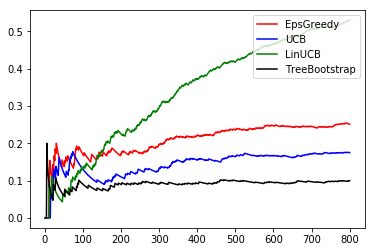

In [16]:
fig = plt.figure()
ax = plt.axes()
ax.plot(T, get_results(results_EpsGreedy), 'r', label='EpsGreedy')
ax.plot(T, get_results(results_UCB), 'b', label='UCB')
ax.plot(T, get_results(results_LinUCB), 'g', label='LinUCB')
ax.plot(T, get_results(results_TreeBootstrap), 'k', label='TreeBootstrap')
ax.legend(loc='upper right')

### 5.B.

In [17]:
alphas = np.arange(0.1, 2.2, 0.2)
scores = []
max_score = 0
max_alpha = 0
for alpha in alphas:
    
    score = np.mean(offlineEvaluate(LinUCB(10, 10, alpha), arms, rewards, contexts, 800))
    scores.append(score)

    if score > max_score:
        max_score = score
        max_alpha = alpha
        
print("Max score: " + str(max_score))
print("alpha: " + str(max_alpha))

Max score: 0.70875
alpha: 0.1


0.70875 0.1


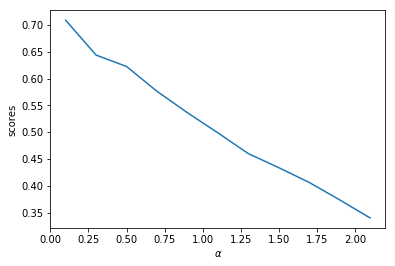

In [18]:
print(max_score, max_alpha)
ax = plt.figure().subplots()
ax.plot(alphas, scores)
ax.set_xlabel(r"$\alpha$")
ax.set_ylabel("scores")
plt.show()

## 6. Implement KernelUCB contextual MAB

In [19]:
class KernelUCB(MAB):
    """Kernelised contextual multi-armed bandit (Kernelised LinUCB)
    
    Parameters
    ----------
    n_arms : int
        Number of arms.

    n_dims : int
        Number of features for each arm's context.

    gamma : float
        Positive real explore-exploit parameter.
    
    eta : float
        Positive real explore-exploit parameter.
    
    kern : callable
        A kernel function from sklearn.metrics.pairwise.
    """
    def __init__(self, n_arms, n_dims, gamma, eta, kern):
        super().__init__(n_arms)
        # your code here
        
        self.n_dims = n_dims
        self.gamma = gamma
        self.eta = eta
        self.kern = kern
        self.count_arms = [0 for i in range(self.n_arms)]
        self.mu_t = list([1] + [0]*(self.n_arms-1))
        self.y = []
        self.xt_history = []
        self.K_t1_inv = None
        self.yt = None

        
    def play(self, context):
        super().play(context)
        # your code here
        
        pre_t = sum(self.count_arms)
        t = pre_t + 1
        mu_t = [0 for i in range(self.n_arms)]
        
        if t != 1:

            for i in range(self.n_arms):
                x_at = np.array(context[i*10 : (i+1)*10])
                c = np.array([self.kern(x_at.reshape(1, -1), xt_h.reshape(1, -1)) for xt_h in self.xt_history]).reshape(-1, 1)
                sigma_at = np.sqrt(self.kern(x_at.reshape(1, -1), x_at.reshape(1, -1)) - np.linalg.multi_dot([c.T, self.K_t1_inv, c]))
                mu_t[i] = np.linalg.multi_dot([c.T, self.K_t1_inv, self.yt]) + self.eta / np.sqrt(self.gamma) * sigma_at      
        
        # argmax
        return probably_exploit(mu_t)
        
    
    def update(self, arm, reward, context):
        super().update(arm, reward, context)
        # your code here
        
        pre_t = sum(self.count_arms)
        t = pre_t + 1  
        xt = context[arm*10 : (arm+1)*10].reshape(-1, 1)
        self.xt_history.append(xt)
        self.y.append(reward)
        self.yt = np.array(self.y).reshape(-1, 1)
        yt_1 = np.array(self.y).reshape(-1, 1)
        
        if t == 1:
            self.K_t1_inv = 1 / (self.kern(xt.reshape(1, -1), xt.reshape(1, -1)) + self.gamma)
        else:
            b = np.array([self.kern(xt.reshape(1, -1), xt_h.reshape(1, -1)) for xt_h in self.xt_history[:-1]]).reshape(-1, 1)
            Kt_inv = self.K_t1_inv
            K22 = np.linalg.inv(self.kern(xt.reshape(1, -1), xt.reshape(1, -1)) + self.gamma - np.linalg.multi_dot([b.T, Kt_inv, b]))
            K11 = Kt_inv + K22* np.linalg.multi_dot([Kt_inv, b, b.T, Kt_inv])   
            K12 = (-K22) * np.linalg.multi_dot([Kt_inv, b])
            K21 = (-K22) * np.linalg.multi_dot([b.T, Kt_inv])
            a = np.block([[K11, K12], [K21, K22]])
            self.K_t1_inv = a

        pre_num_arm = self.count_arms[arm]
        cur_num_arm = pre_num_arm + 1
        self.count_arms[arm] = cur_num_arm

In [20]:
mab = KernelUCB(10, 10, 1.0, 0.1, rbf_kernel)
results_KernelUCB = offlineEvaluate(mab, arms, rewards, contexts, 800)
print('KernelUCB average reward', np.mean(results_KernelUCB))

KernelUCB average reward 0.69875


In [21]:
max_score = 0
max_gamma = 0
max_eta = 0
max_results_KernelUCB = []

gammas = [0.1, 0.3, 0.5, 0.7, 1.0]
etas = [0.1, 0.3, 0.5, 0.7, 1.0]

for gamma in gammas:
    for eta in etas:
        
        mab = KernelUCB(10, 10, gamma, eta, rbf_kernel)
        results_KernelUCB = offlineEvaluate(mab, arms, rewards, contexts, 800)
        score = np.mean(results_KernelUCB)
        
        if score > max_score: 
            max_score = score
            max_gamma = gamma
            max_eta = eta
            max_results_KernelUCB = results_KernelUCB
                
print("Max score: "+ str(max_score))
print("gamma: " + str(max_gamma) + " eta: " + str(max_eta))

Max score: 0.785
gamma: 1.0 eta: 0.5


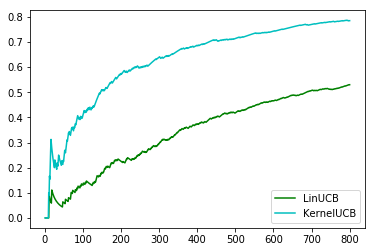

In [22]:
fig = plt.figure()
ax = plt.axes()
x = np.linspace(1, 800, 800)
ax.plot(T, get_results(results_LinUCB), 'g', label='LinUCB')
ax.plot(T, get_results(max_results_KernelUCB), 'c', label='KernelUCB')
ax.legend(loc='lower right')